In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../Data\cifar-10-python.tar.gz to ../Data
Files already downloaded and verified


In [18]:
torch.manual_seed(101)  # for reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [19]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [25]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

Label: [    9     9     6     5     6     2     7     2     4     2]
Class:  truck truck  frog   dog  frog  bird horse  bird  deer  bird


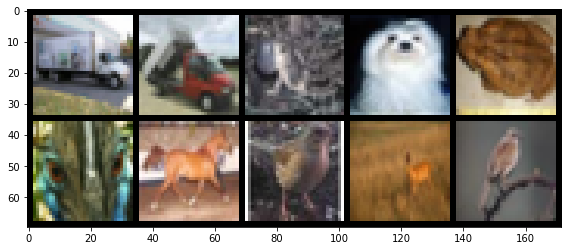

In [24]:
#np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [29]:
images[0].shape

torch.Size([3, 32, 32])

In [ ]:
# Pooling; -2 due to convolution edge loss, /2 pooling
(((32-2)/2)-2)/2

6.5 rounded down to 6 -> 6*6 in Linear layer

In [35]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5,1)  # (1,6,5,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(6*6*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,6*6*16)  # flatten out
        X = F.relu(self.fc1(X))  # no embedding?
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)  # dimension along 1

In [36]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [37]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [38]:
#81302 parameters

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [40]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 2.11886144  accuracy:  26.900%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.80094111  accuracy:  32.650%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.01839793  accuracy:  35.930%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.21529043  accuracy:  37.947%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.41237652  accuracy:  39.704%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.29774022  accuracy:  48.600%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.20678484  accuracy:  49.060%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.25467610  accuracy:  49.717%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.01219809  accuracy:  50.140%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 2.11217356  accuracy:  50.614%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.70887685  accuracy:  54.450%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.33233285  accuracy:  54.435%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.46611440  accuracy:  55.113%
epoch:  2  b

In [41]:
torch.save(model.state_dict(),'myCIFARmodel.pt')

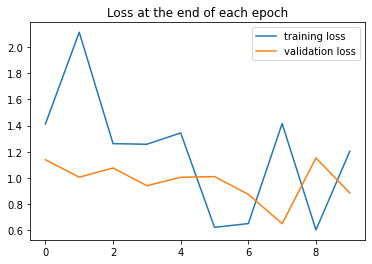

In [42]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

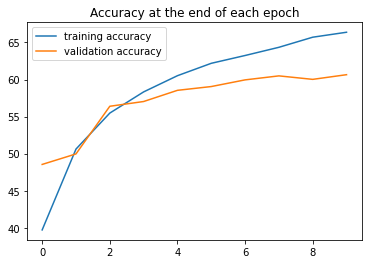

In [43]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [46]:
print(test_correct)

[tensor(4854), tensor(4996), tensor(5639), tensor(5703), tensor(5854), tensor(5905), tensor(5995), tensor(6049), tensor(6002), tensor(6065)]


In [48]:
num_c = test_correct[-1].item()
num_c*100/10000

60.65

# Seaborn Heatmap

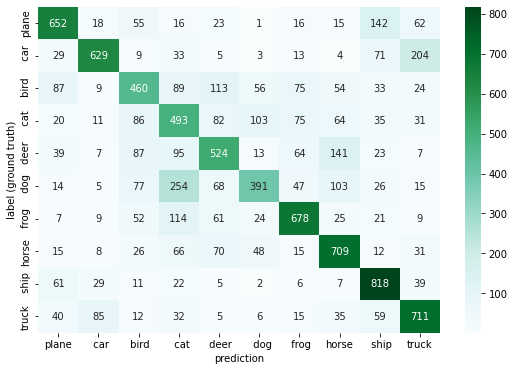

In [49]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();